# Sprint 4 - Teste dos Modelos CNN Treinados

Este notebook testa os 3 modelos CNN customizados treinados do zero:

- **CustomCNN1**: Lightweight mas eficaz
- **CustomCNN2**: Deeper com conexões residuais  
- **CustomCNN3**: EfficientNet-inspired com MBConv blocks

## Objetivo:
Testar os modelos com imagens individuais do diretório `assets/img-tests` e analisar o desempenho de cada modelo.

## Classes de Doenças:
- **Cerscospora**: Mancha de Cercospora
- **Healthy**: Folha saudável
- **Leaf rust**: Ferrugem da folha
- **Miner**: Minador da folha
- **Phoma**: Mancha de Phoma


In [1]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd
from pathlib import Path
import time
from collections import Counter
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


Using device: cuda
GPU: NVIDIA RTX 4000 Ada Generation
CUDA Version: 12.8
Memory: 19.5 GB


In [2]:
# Configuration
# Get the project root directory (go up two levels from notebooks/sprint-4/)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

CONFIG = {
    'img_size': 224,
    'class_names': ['Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9'],
    'num_classes': 10,  # Models were trained with 10 classes
    'models_dir': os.path.join(project_root, 'notebooks', 'sprint-4', 'modelos', 'sprint-4'),
    'test_images_dir': os.path.join(project_root, 'assets', 'img-tests')
}

print("Configuration loaded successfully!")
print(f"Number of classes: {CONFIG['num_classes']}")
print(f"Classes: {CONFIG['class_names']}")
print(f"Test images directory: {CONFIG['test_images_dir']}")


Configuration loaded successfully!
Number of classes: 10
Classes: ['Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9']
Test images directory: /home/t21-g112/Desktop/2025-2A-T21-G112-INTERNO/assets/img-tests


In [3]:
# Load the trained CNN architectures (same as in training notebook)
class CustomCNN1(nn.Module):
    """Custom CNN Architecture 1 - Lightweight but effective"""
    def __init__(self, num_classes=5):
        super(CustomCNN1, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Third block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Fourth block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class CustomCNN2(nn.Module):
    """Custom CNN Architecture 2 - Deeper with residual connections"""
    def __init__(self, num_classes=5):
        super(CustomCNN2, self).__init__()
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        
        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
    
    def _make_layer(self, inplanes, planes, blocks, stride=1):
        layers = []
        layers.append(BasicBlock(inplanes, planes, stride))
        for _ in range(1, blocks):
            layers.append(BasicBlock(planes, planes))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class BasicBlock(nn.Module):
    """Basic residual block"""
    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CustomCNN3(nn.Module):
    """Custom CNN Architecture 3 - EfficientNet-inspired"""
    def __init__(self, num_classes=5):
        super(CustomCNN3, self).__init__()
        
        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        
        # MBConv blocks
        self.blocks = nn.Sequential(
            MBConv(32, 16, 1, 1),
            MBConv(16, 24, 6, 2),
            MBConv(24, 40, 6, 2),
            MBConv(40, 80, 6, 2),
            MBConv(80, 112, 6, 1),
            MBConv(112, 192, 6, 2),
            MBConv(192, 320, 6, 1),
        )
        
        # Head
        self.head = nn.Sequential(
            nn.Conv2d(320, 1280, kernel_size=1),
            nn.BatchNorm2d(1280),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )
    
    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        return x

class MBConv(nn.Module):
    """Mobile Inverted Bottleneck Convolution"""
    def __init__(self, in_channels, out_channels, expansion_factor, stride):
        super(MBConv, self).__init__()
        self.stride = stride
        self.use_residual = stride == 1 and in_channels == out_channels
        
        expanded_channels = in_channels * expansion_factor
        
        # Expansion
        self.expand = nn.Conv2d(in_channels, expanded_channels, 1, bias=False)
        self.expand_bn = nn.BatchNorm2d(expanded_channels)
        
        # Depthwise
        self.depthwise = nn.Conv2d(expanded_channels, expanded_channels, 3, stride, 1, groups=expanded_channels, bias=False)
        self.depthwise_bn = nn.BatchNorm2d(expanded_channels)
        
        # Projection
        self.project = nn.Conv2d(expanded_channels, out_channels, 1, bias=False)
        self.project_bn = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        residual = x
        
        x = F.relu(self.expand_bn(self.expand(x)))
        x = F.relu(self.depthwise_bn(self.depthwise(x)))
        x = self.project_bn(self.project(x))
        
        if self.use_residual:
            x += residual
        
        return x

print("CNN architectures loaded successfully!")


CNN architectures loaded successfully!


In [4]:
# Load trained models
def load_trained_models():
    """Load the trained CNN models"""
    models = {}
    model_architectures = {
        'CustomCNN1': CustomCNN1,
        'CustomCNN2': CustomCNN2, 
        'CustomCNN3': CustomCNN3
    }
    
    for model_name, model_class in model_architectures.items():
        model_path = os.path.join(CONFIG['models_dir'], f'{model_name}_best.pth')
        
        if os.path.exists(model_path):
            try:
                # Create model instance
                model = model_class(num_classes=CONFIG['num_classes'])
                
                # Load trained weights
                state_dict = torch.load(model_path, map_location=device)
                model.load_state_dict(state_dict)
                model.to(device)
                model.eval()
                
                models[model_name] = model
                print(f"✅ Loaded {model_name} from {model_path}")
                
            except Exception as e:
                print(f"❌ Error loading {model_name}: {e}")
        else:
            print(f"❌ Model file not found: {model_path}")
    
    return models

# Load models
print("🔄 Loading trained models...")
trained_models = load_trained_models()

if trained_models:
    print(f"\n✅ Successfully loaded {len(trained_models)} models:")
    for name in trained_models.keys():
        print(f"   - {name}")
else:
    print("❌ No models loaded! Please check if the model files exist.")


🔄 Loading trained models...
✅ Loaded CustomCNN1 from /home/t21-g112/Desktop/2025-2A-T21-G112-INTERNO/notebooks/sprint-4/modelos/sprint-4/CustomCNN1_best.pth
✅ Loaded CustomCNN2 from /home/t21-g112/Desktop/2025-2A-T21-G112-INTERNO/notebooks/sprint-4/modelos/sprint-4/CustomCNN2_best.pth
✅ Loaded CustomCNN3 from /home/t21-g112/Desktop/2025-2A-T21-G112-INTERNO/notebooks/sprint-4/modelos/sprint-4/CustomCNN3_best.pth

✅ Successfully loaded 3 models:
   - CustomCNN1
   - CustomCNN2
   - CustomCNN3


In [5]:
# Image preprocessing and testing functions
class ImageTester:
    """Test individual images with trained models"""
    
    def __init__(self, models, class_names, device):
        self.models = models
        self.class_names = class_names
        self.device = device
        
        # Image preprocessing
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    def preprocess_image(self, image_path):
        """Preprocess image for testing"""
        try:
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.transform(image)
            image_tensor = image_tensor.unsqueeze(0)
            return image_tensor.to(self.device)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            return None
    
    def predict_image(self, model, image_tensor):
        """Get prediction from a single model"""
        model.eval()
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted_class = torch.max(probabilities, 1)
        
        return {
            'predicted_class': self.class_names[predicted_class.item()],
            'confidence': confidence.item(),
            'probabilities': probabilities.cpu().numpy()[0]
        }
    
    def test_all_models(self, image_path):
        """Test image with all models"""
        image_tensor = self.preprocess_image(image_path)
        if image_tensor is None:
            return None
        
        results = {
            'image_name': Path(image_path).name,
            'image_path': image_path,
            'predictions': {}
        }
        
        for model_name, model in self.models.items():
            prediction = self.predict_image(model, image_tensor)
            results['predictions'][model_name] = prediction
        
        return results
    
    def display_results(self, image_path, results):
        """Display image with predictions"""
        try:
            # Load and display image
            image = Image.open(image_path).convert('RGB')
            
            fig, axes = plt.subplots(1, 2, figsize=(16, 8))
            
            # Show image
            axes[0].imshow(image)
            axes[0].set_title(f"Test Image: {Path(image_path).name}", fontsize=14, fontweight='bold')
            axes[0].axis('off')
            
            # Show predictions
            axes[1].axis('off')
            prediction_text = f"Model Predictions:\n\n"
            
            for model_name, pred_data in results['predictions'].items():
                prediction_text += f"🔍 {model_name}:\n"
                prediction_text += f"   Predicted: {pred_data['predicted_class']}\n"
                prediction_text += f"   Confidence: {pred_data['confidence']:.3f}\n\n"
            
            # Add probability breakdown
            prediction_text += "\nDetailed Probabilities:\n"
            for model_name, pred_data in results['predictions'].items():
                prediction_text += f"\n{model_name}:\n"
                for i, (class_name, prob) in enumerate(zip(self.class_names, pred_data['probabilities'])):
                    prediction_text += f"  {class_name}: {prob:.3f}\n"
            
            axes[1].text(0.05, 0.95, prediction_text, transform=axes[1].transAxes, 
                        fontsize=10, verticalalignment='top', fontfamily='monospace')
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error displaying image {image_path}: {e}")

print("Image testing functions loaded successfully!")


Image testing functions loaded successfully!


In [6]:
# Load test images and initialize tester
if trained_models:
    print("🔍 Loading test images...")
    
    # Get all test images
    test_images = []
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.JPG', '.JPEG', '.PNG'}
    
    for file_path in Path(CONFIG['test_images_dir']).iterdir():
        if file_path.suffix.lower() in image_extensions:
            test_images.append(str(file_path))
    
    test_images = sorted(test_images)
    
    print(f"✅ Found {len(test_images)} test images")
    
    # Initialize tester
    tester = ImageTester(trained_models, CONFIG['class_names'], device)
    
    # Show some sample images
    print("\n📸 Sample test images:")
    for i, img_path in enumerate(test_images[:5]):
        print(f"   {i+1}. {Path(img_path).name}")
    
    if len(test_images) > 5:
        print(f"   ... and {len(test_images) - 5} more images")
        
else:
    print("❌ No trained models available for testing!")


🔍 Loading test images...
✅ Found 40 test images

📸 Sample test images:
   1. healthy.jpg
   2. healthy0.jpg
   3. healthy2.jpg
   4. healthy3.jpg
   5. healthy4.jpg
   ... and 35 more images


🧪 Testing individual images with all models...

--- Testing Image 1/10: healthy.jpg ---


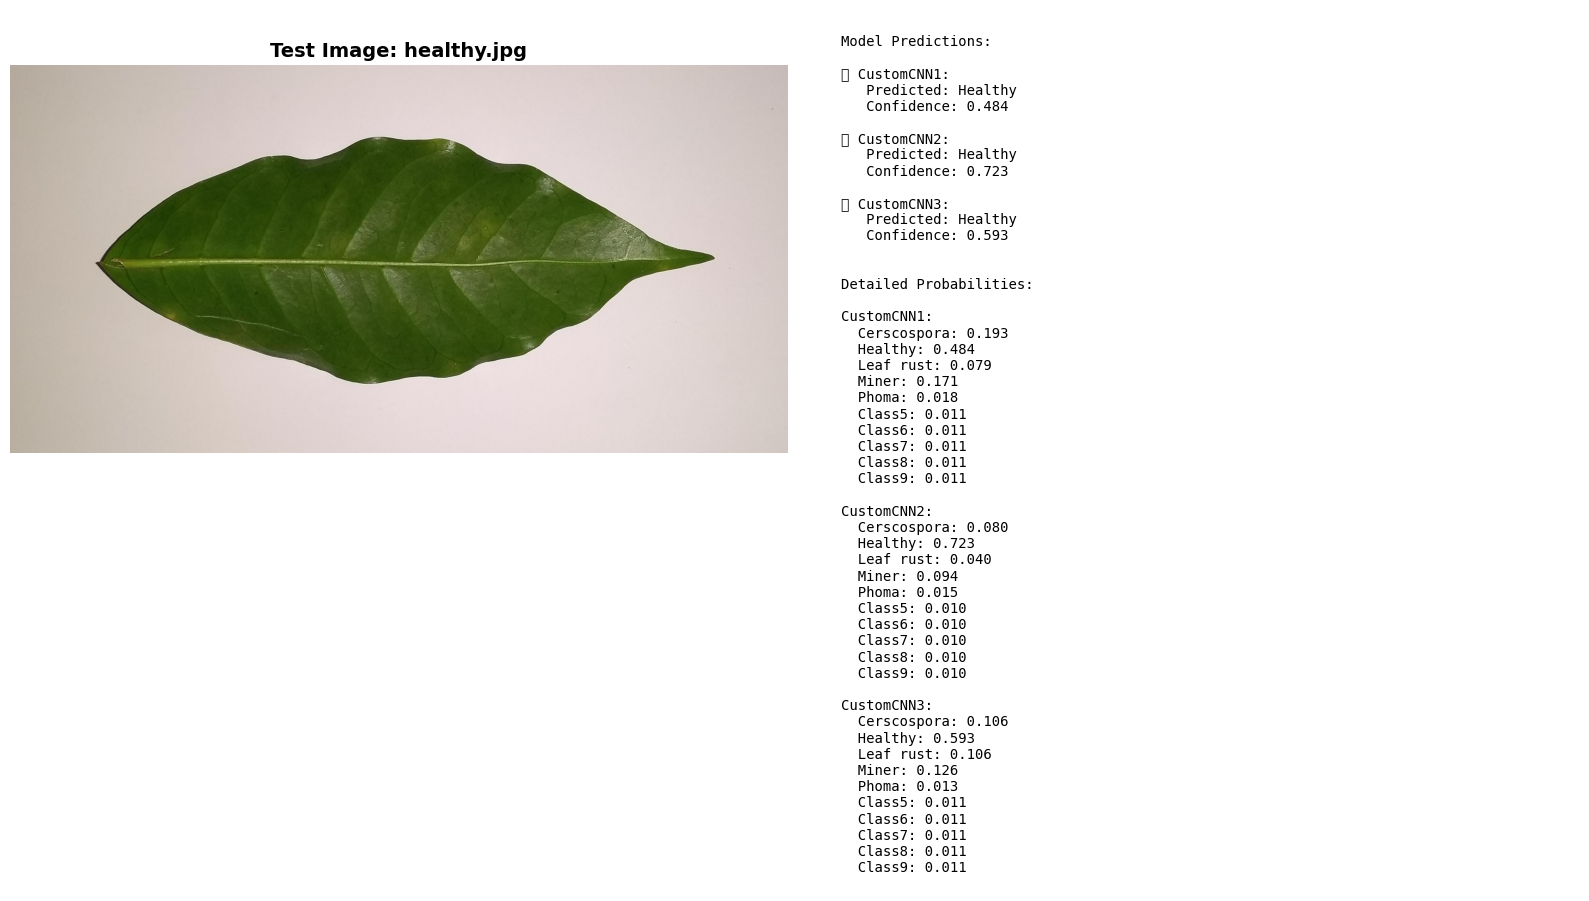


📊 Summary for healthy.jpg:
   CustomCNN1: Healthy (confidence: 0.484)
   CustomCNN2: Healthy (confidence: 0.723)
   CustomCNN3: Healthy (confidence: 0.593)
------------------------------------------------------------

--- Testing Image 2/10: healthy0.jpg ---


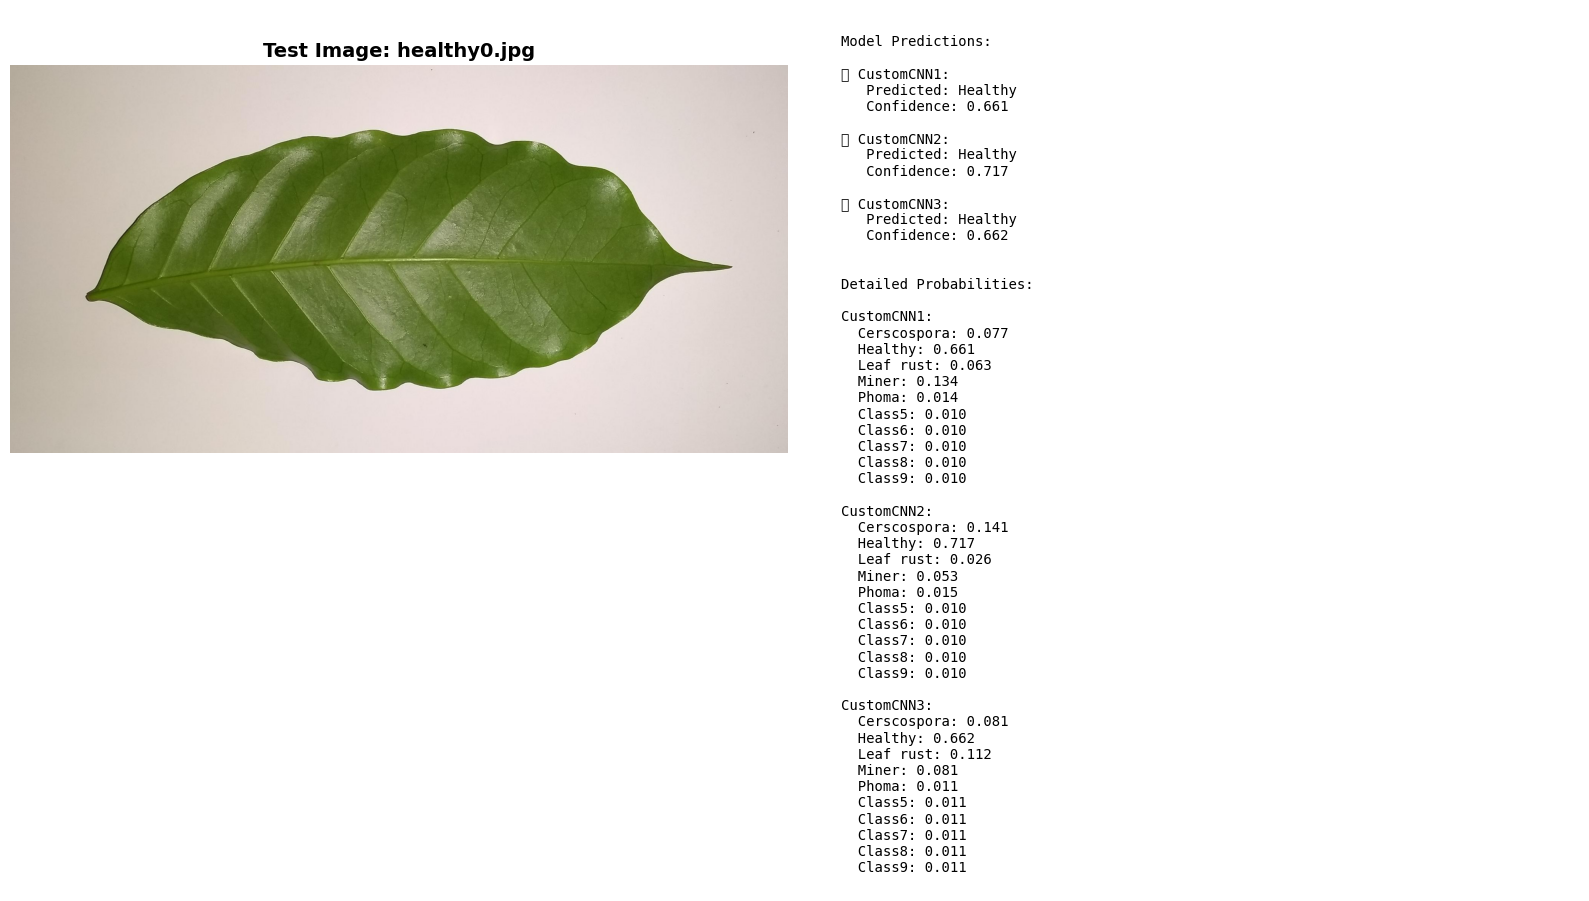


📊 Summary for healthy0.jpg:
   CustomCNN1: Healthy (confidence: 0.661)
   CustomCNN2: Healthy (confidence: 0.717)
   CustomCNN3: Healthy (confidence: 0.662)
------------------------------------------------------------

--- Testing Image 3/10: healthy2.jpg ---


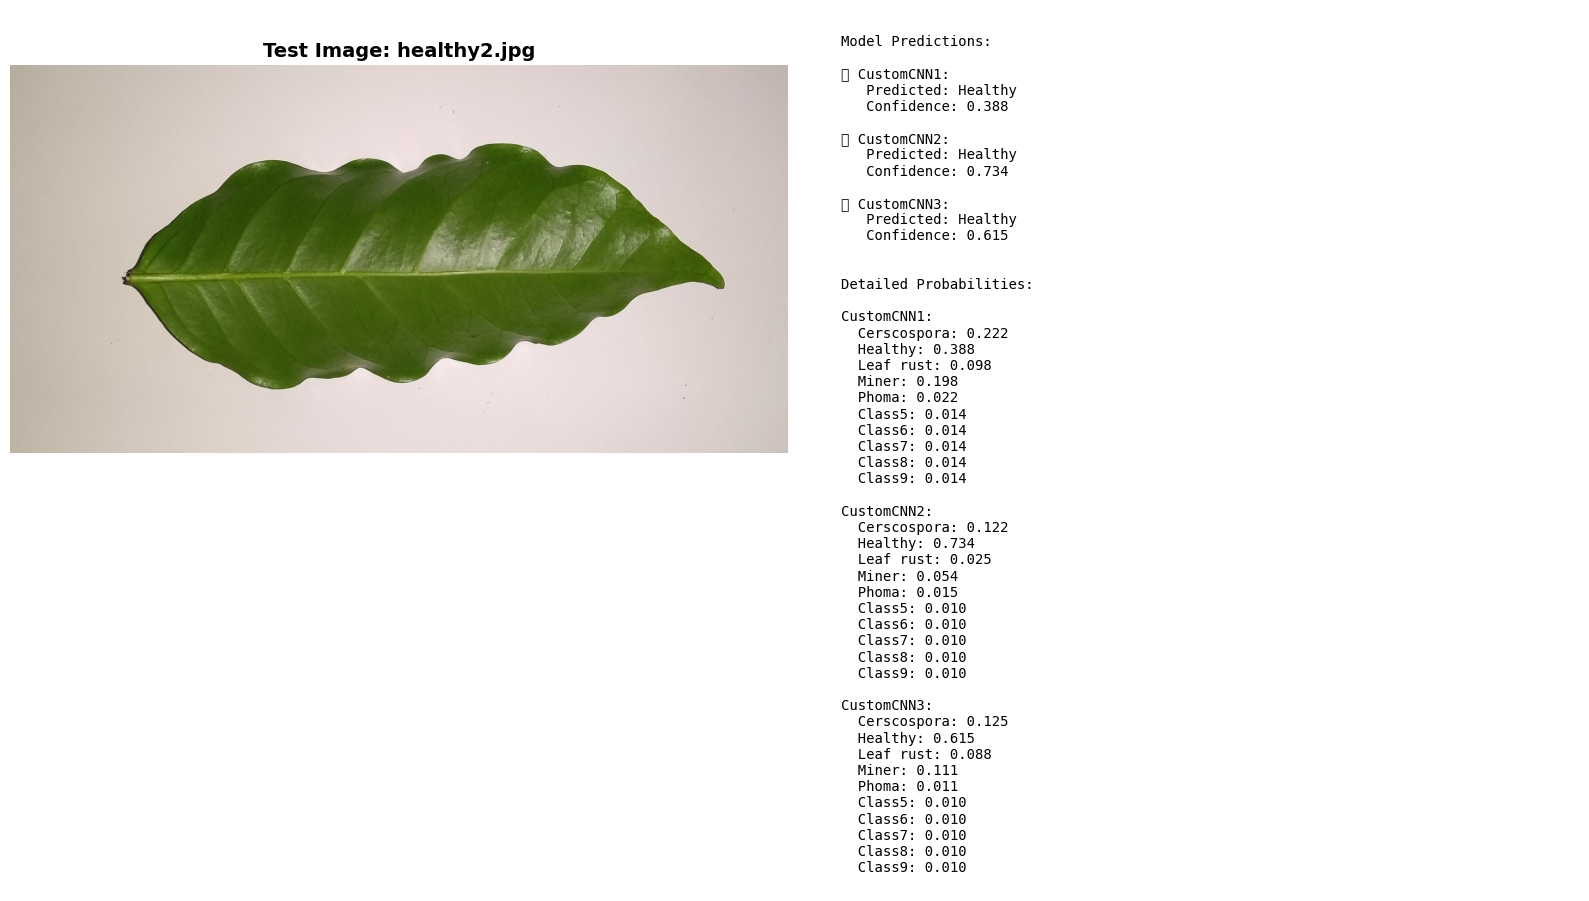


📊 Summary for healthy2.jpg:
   CustomCNN1: Healthy (confidence: 0.388)
   CustomCNN2: Healthy (confidence: 0.734)
   CustomCNN3: Healthy (confidence: 0.615)
------------------------------------------------------------

--- Testing Image 4/10: healthy3.jpg ---


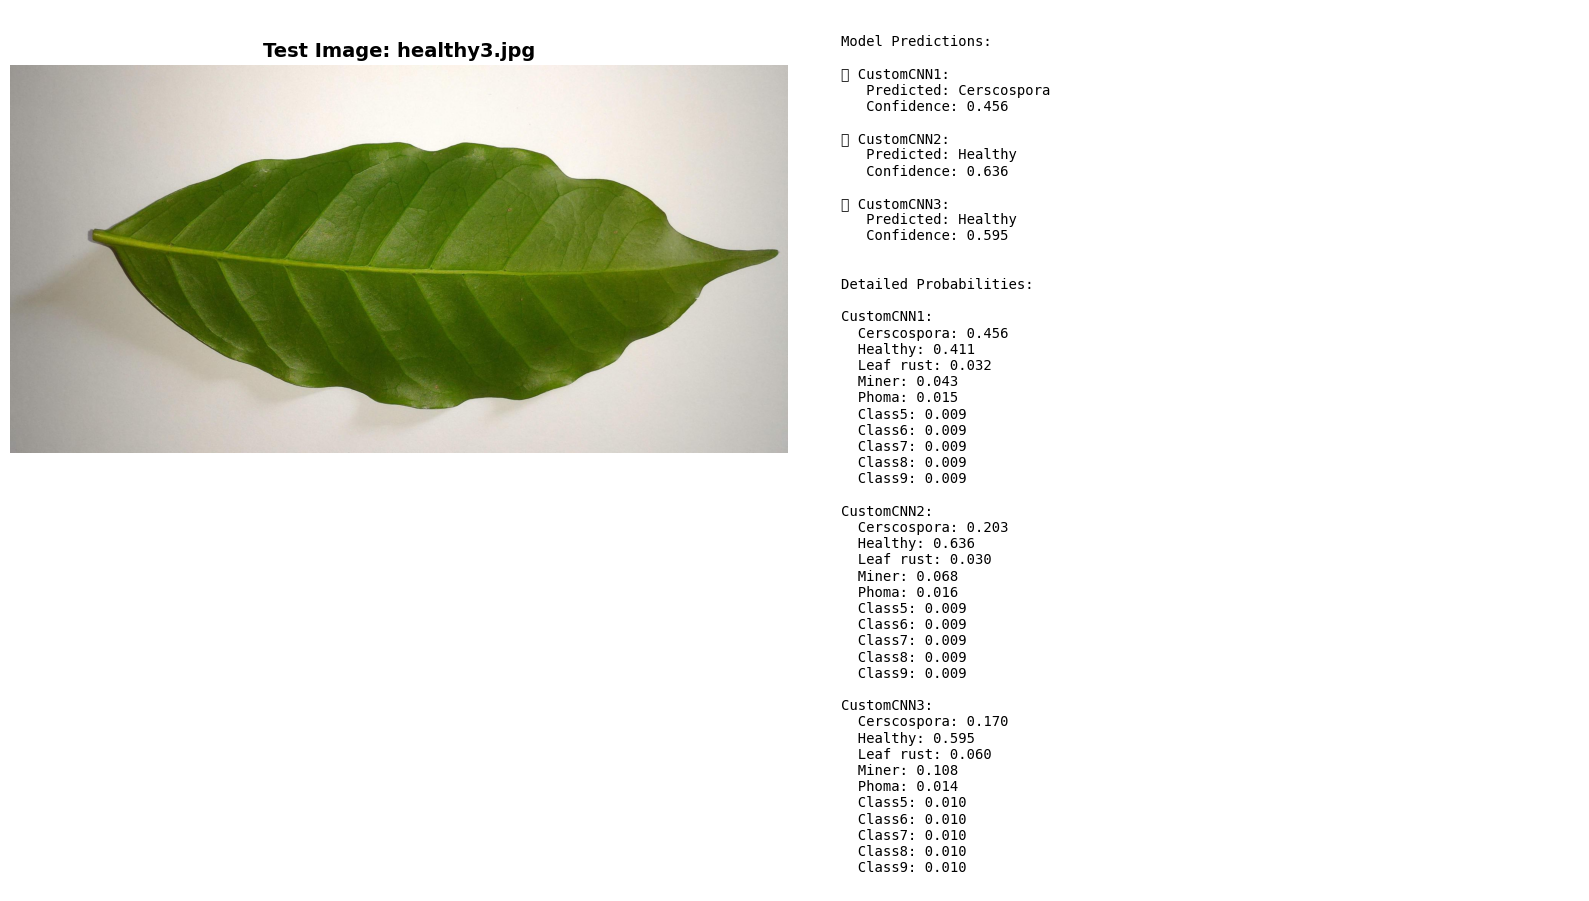


📊 Summary for healthy3.jpg:
   CustomCNN1: Cerscospora (confidence: 0.456)
   CustomCNN2: Healthy (confidence: 0.636)
   CustomCNN3: Healthy (confidence: 0.595)
------------------------------------------------------------

--- Testing Image 5/10: healthy4.jpg ---


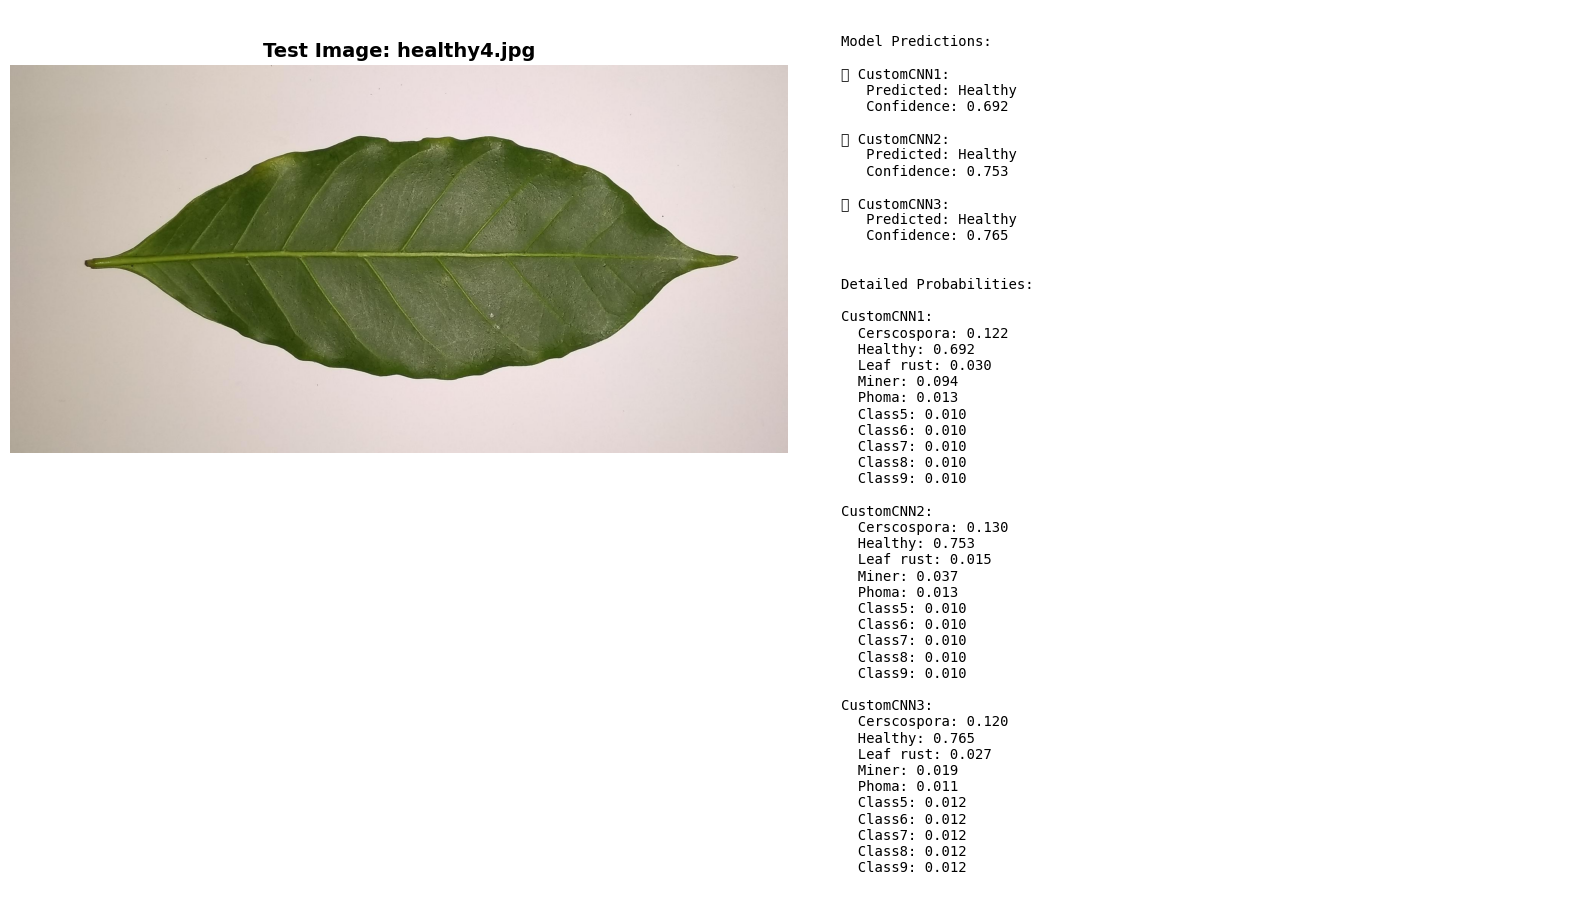


📊 Summary for healthy4.jpg:
   CustomCNN1: Healthy (confidence: 0.692)
   CustomCNN2: Healthy (confidence: 0.753)
   CustomCNN3: Healthy (confidence: 0.765)
------------------------------------------------------------

--- Testing Image 6/10: healthy5.jpg ---


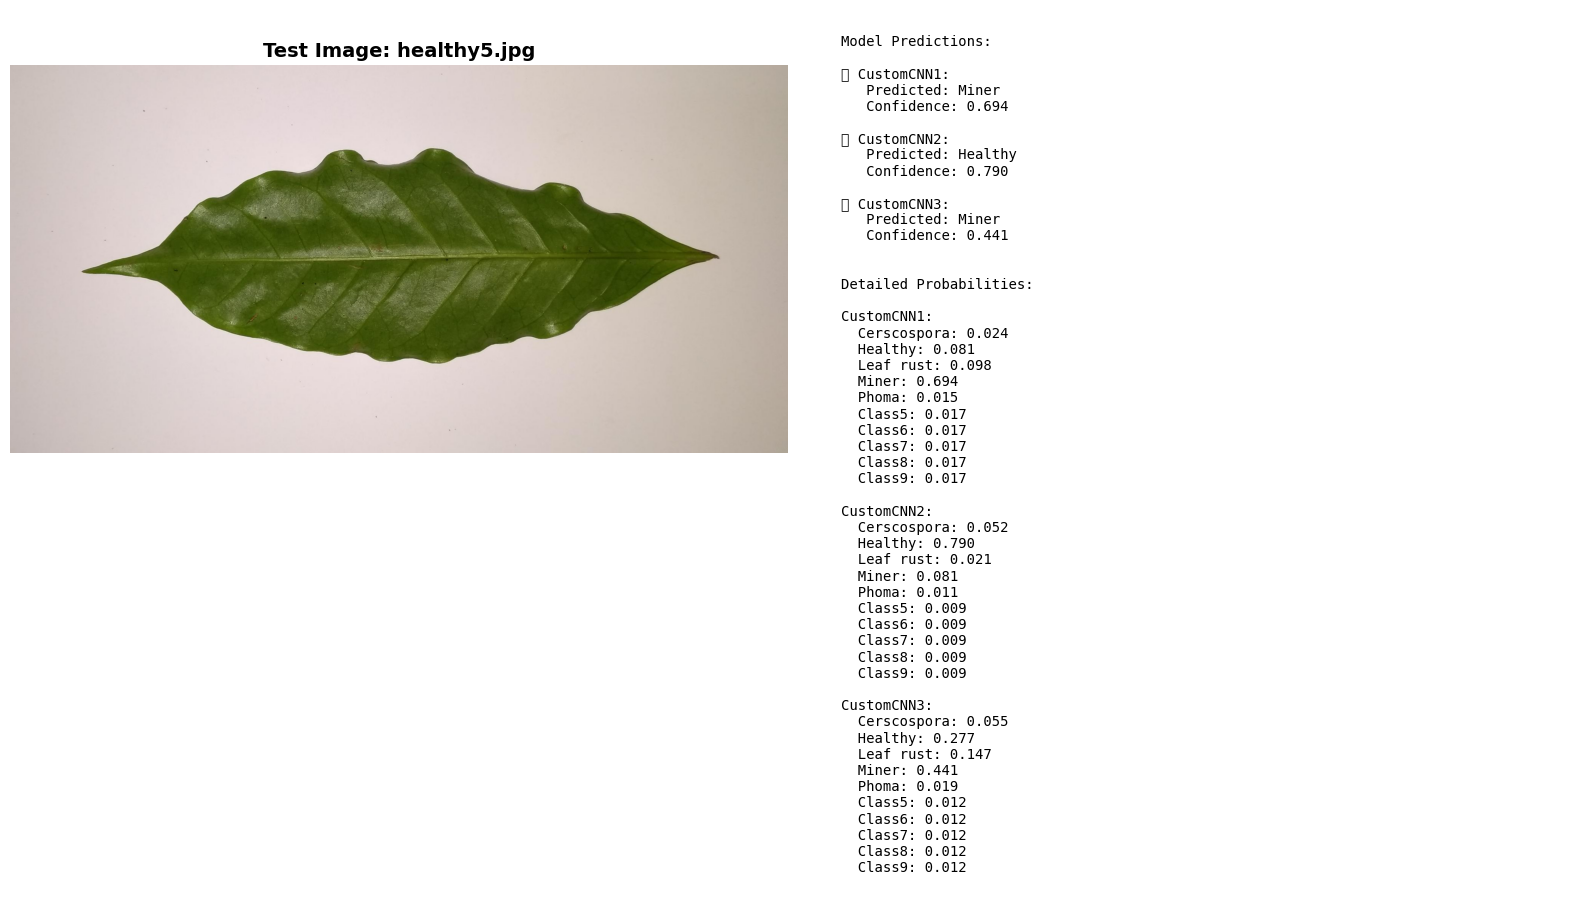


📊 Summary for healthy5.jpg:
   CustomCNN1: Miner (confidence: 0.694)
   CustomCNN2: Healthy (confidence: 0.790)
   CustomCNN3: Miner (confidence: 0.441)
------------------------------------------------------------

--- Testing Image 7/10: healthy6.jpg ---


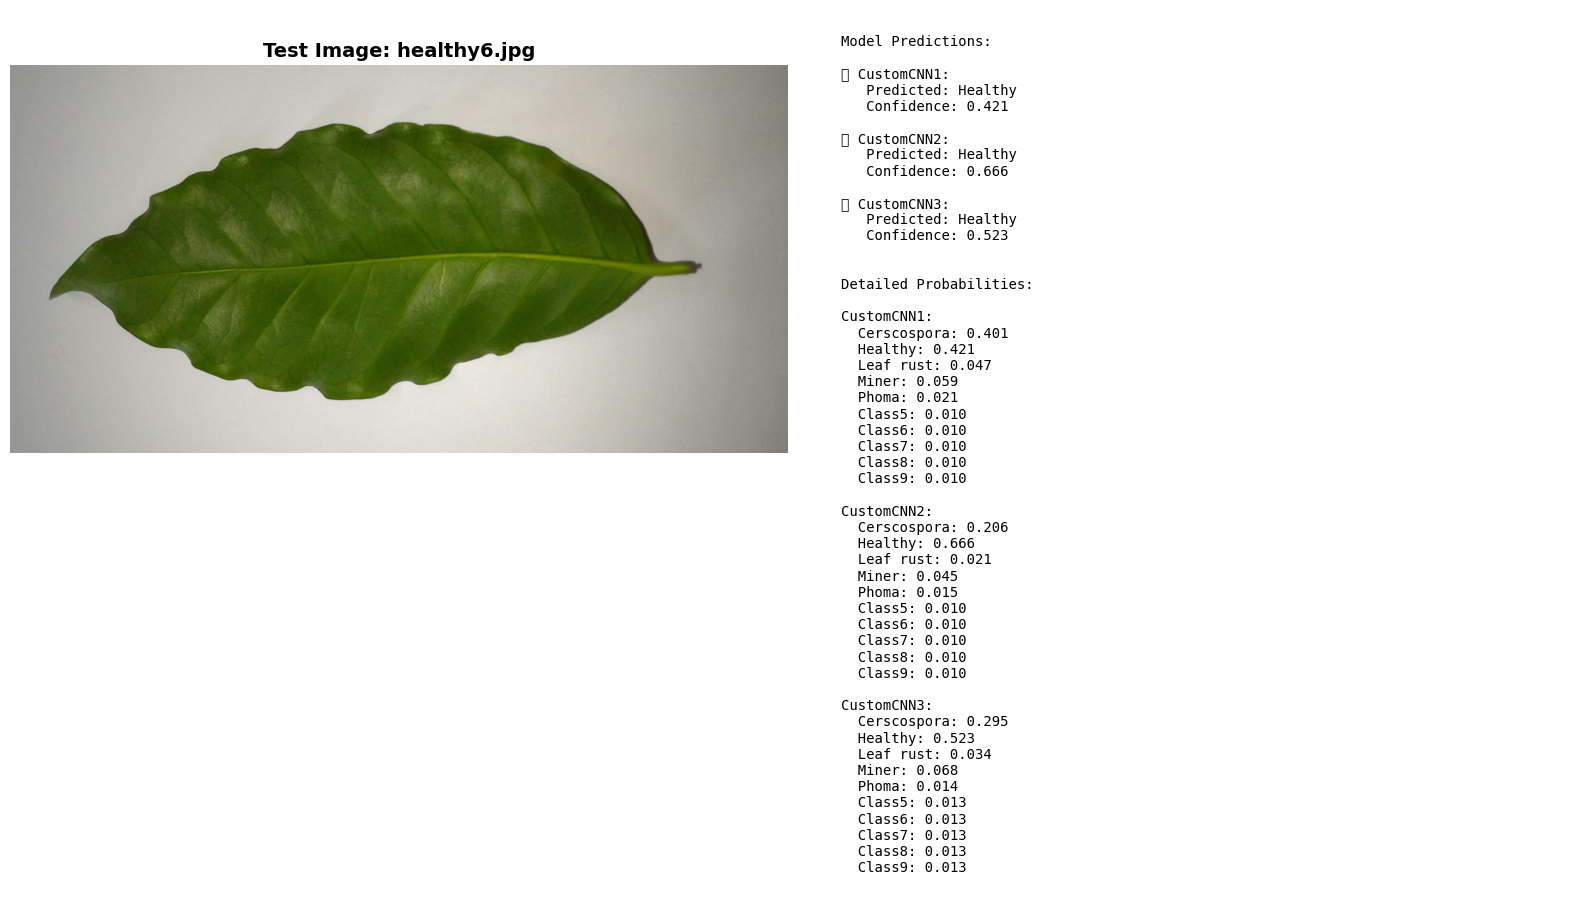


📊 Summary for healthy6.jpg:
   CustomCNN1: Healthy (confidence: 0.421)
   CustomCNN2: Healthy (confidence: 0.666)
   CustomCNN3: Healthy (confidence: 0.523)
------------------------------------------------------------

--- Testing Image 8/10: healthy7.jpg ---


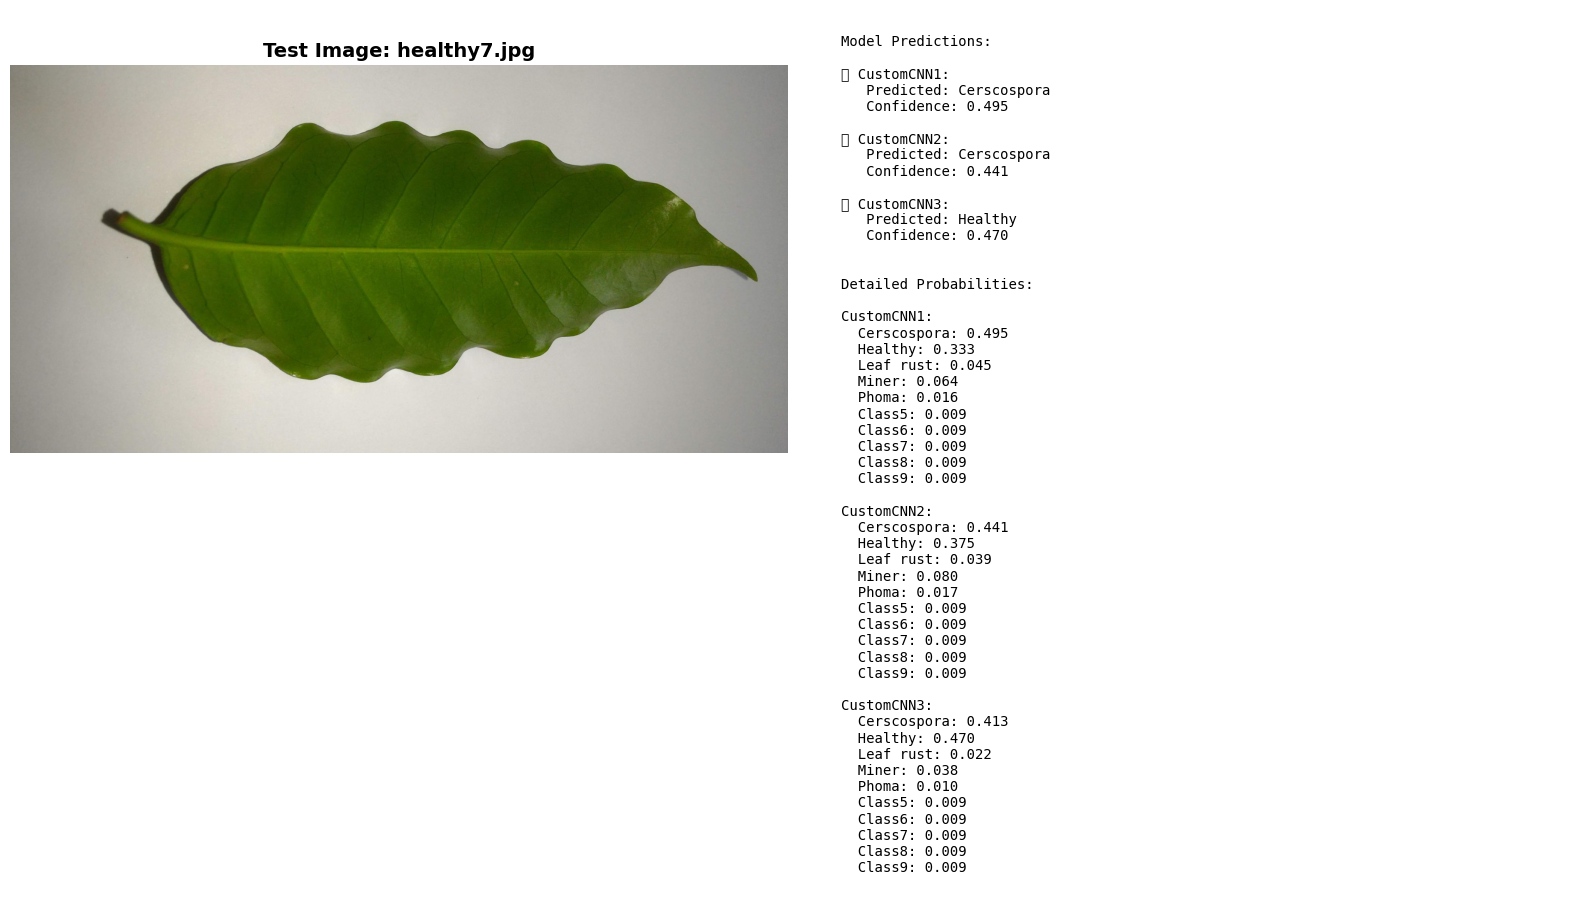


📊 Summary for healthy7.jpg:
   CustomCNN1: Cerscospora (confidence: 0.495)
   CustomCNN2: Cerscospora (confidence: 0.441)
   CustomCNN3: Healthy (confidence: 0.470)
------------------------------------------------------------

--- Testing Image 9/10: healthy8.jpg ---


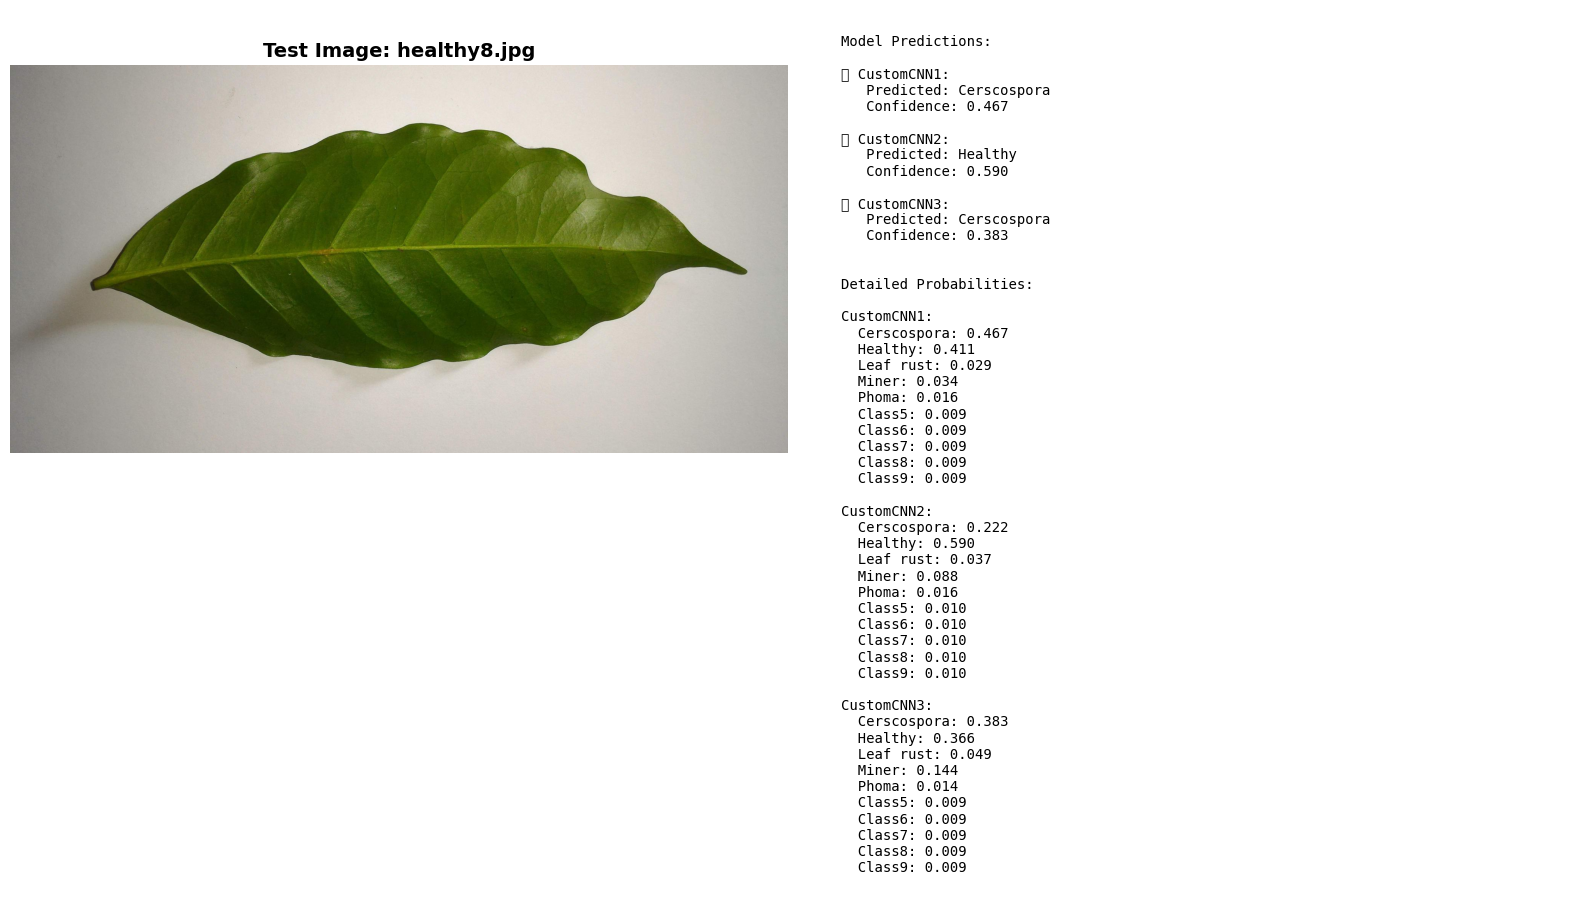


📊 Summary for healthy8.jpg:
   CustomCNN1: Cerscospora (confidence: 0.467)
   CustomCNN2: Healthy (confidence: 0.590)
   CustomCNN3: Cerscospora (confidence: 0.383)
------------------------------------------------------------

--- Testing Image 10/10: healthy9.jpg ---


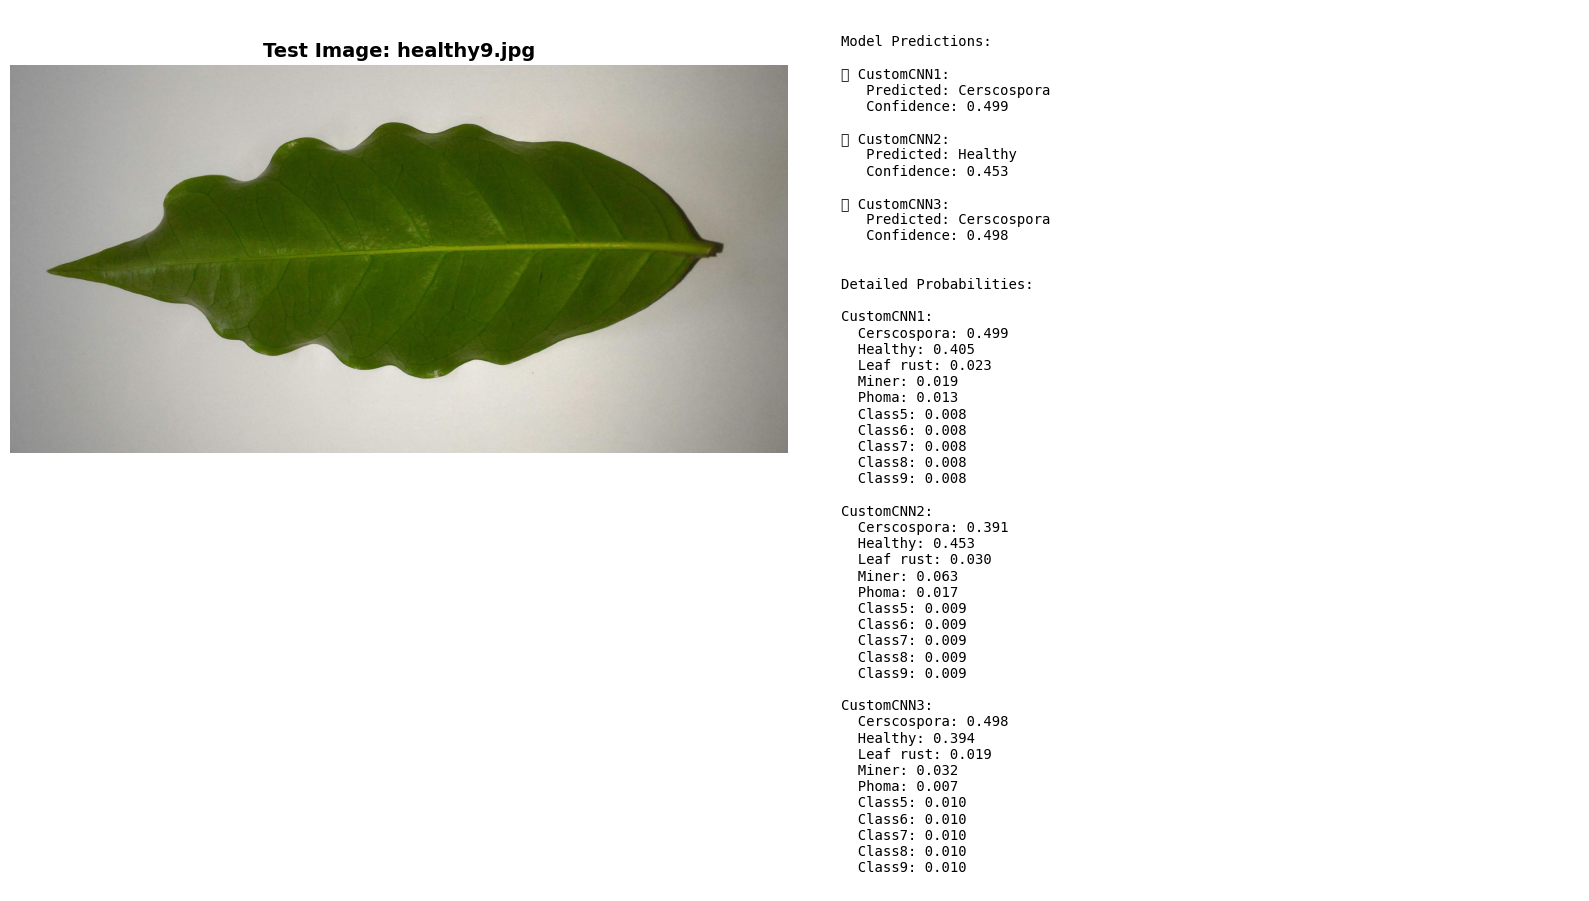


📊 Summary for healthy9.jpg:
   CustomCNN1: Cerscospora (confidence: 0.499)
   CustomCNN2: Healthy (confidence: 0.453)
   CustomCNN3: Cerscospora (confidence: 0.498)
------------------------------------------------------------

✅ Completed testing of 10 images!
Total images available: 40


In [7]:
# Test individual images with detailed results
if trained_models and test_images:
    print("🧪 Testing individual images with all models...")
    print("=" * 60)
    
    # Test first 10 images with detailed display
    num_test_images = min(10, len(test_images))
    
    for i, image_path in enumerate(test_images[:num_test_images]):
        print(f"\n--- Testing Image {i+1}/{num_test_images}: {Path(image_path).name} ---")
        
        # Test with all models
        results = tester.test_all_models(image_path)
        
        if results:
            # Display results
            tester.display_results(image_path, results)
            
            # Print summary
            print(f"\n📊 Summary for {Path(image_path).name}:")
            for model_name, pred_data in results['predictions'].items():
                print(f"   {model_name}: {pred_data['predicted_class']} (confidence: {pred_data['confidence']:.3f})")
        else:
            print(f"❌ Error testing {Path(image_path).name}")
        
        print("-" * 60)
    
    print(f"\n✅ Completed testing of {num_test_images} images!")
    print(f"Total images available: {len(test_images)}")
    
else:
    print("❌ Cannot test - no models or images available!")


In [8]:
# Interactive testing function
def test_single_image(image_path):
    """Test a single image interactively"""
    if not trained_models:
        print("❌ No trained models available!")
        return
    
    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_path}")
        return
    
    print(f"🔍 Testing: {Path(image_path).name}")
    print("=" * 50)
    
    results = tester.test_all_models(image_path)
    if results:
        tester.display_results(image_path, results)
        
        # Print detailed analysis
        print(f"\n📊 Detailed Analysis for {Path(image_path).name}:")
        print("-" * 50)
        
        for model_name, pred_data in results['predictions'].items():
            print(f"\n🔍 {model_name}:")
            print(f"   Predicted Class: {pred_data['predicted_class']}")
            print(f"   Confidence: {pred_data['confidence']:.3f}")
            print(f"   Probabilities:")
            for class_name, prob in zip(CONFIG['class_names'], pred_data['probabilities']):
                print(f"     {class_name}: {prob:.3f}")
    else:
        print("❌ Error testing image")

# Example usage:
# test_single_image("./assets/img-tests/healthy.jpg")

print("Interactive testing function loaded!")
print("Use: test_single_image('path/to/image.jpg') to test any image")


Interactive testing function loaded!
Use: test_single_image('path/to/image.jpg') to test any image


📊 Running comprehensive analysis on all test images...
Processing image 1/40: healthy.jpg
Processing image 11/40: mine0.jpg
Processing image 21/40: phoma0.jpg
Processing image 31/40: rust0.jpg
✅ Processed 40 images successfully!

📈 Model Performance Analysis:

🔍 CustomCNN1:
   Average Confidence: 0.557
   Min Confidence: 0.330
   Max Confidence: 0.854
   Std Confidence: 0.126
   Total Predictions: 40
   Class Distribution:
     Miner: 22 (55.0%)
     Cerscospora: 11 (27.5%)
     Healthy: 6 (15.0%)
     Leaf rust: 1 (2.5%)

🔍 CustomCNN2:
   Average Confidence: 0.584
   Min Confidence: 0.323
   Max Confidence: 0.826
   Std Confidence: 0.110
   Total Predictions: 40
   Class Distribution:
     Miner: 19 (47.5%)
     Healthy: 9 (22.5%)
     Cerscospora: 8 (20.0%)
     Leaf rust: 4 (10.0%)

🔍 CustomCNN3:
   Average Confidence: 0.609
   Min Confidence: 0.315
   Max Confidence: 0.871
   Std Confidence: 0.150
   Total Predictions: 40
   Class Distribution:
     Miner: 19 (47.5%)
     Healthy: 

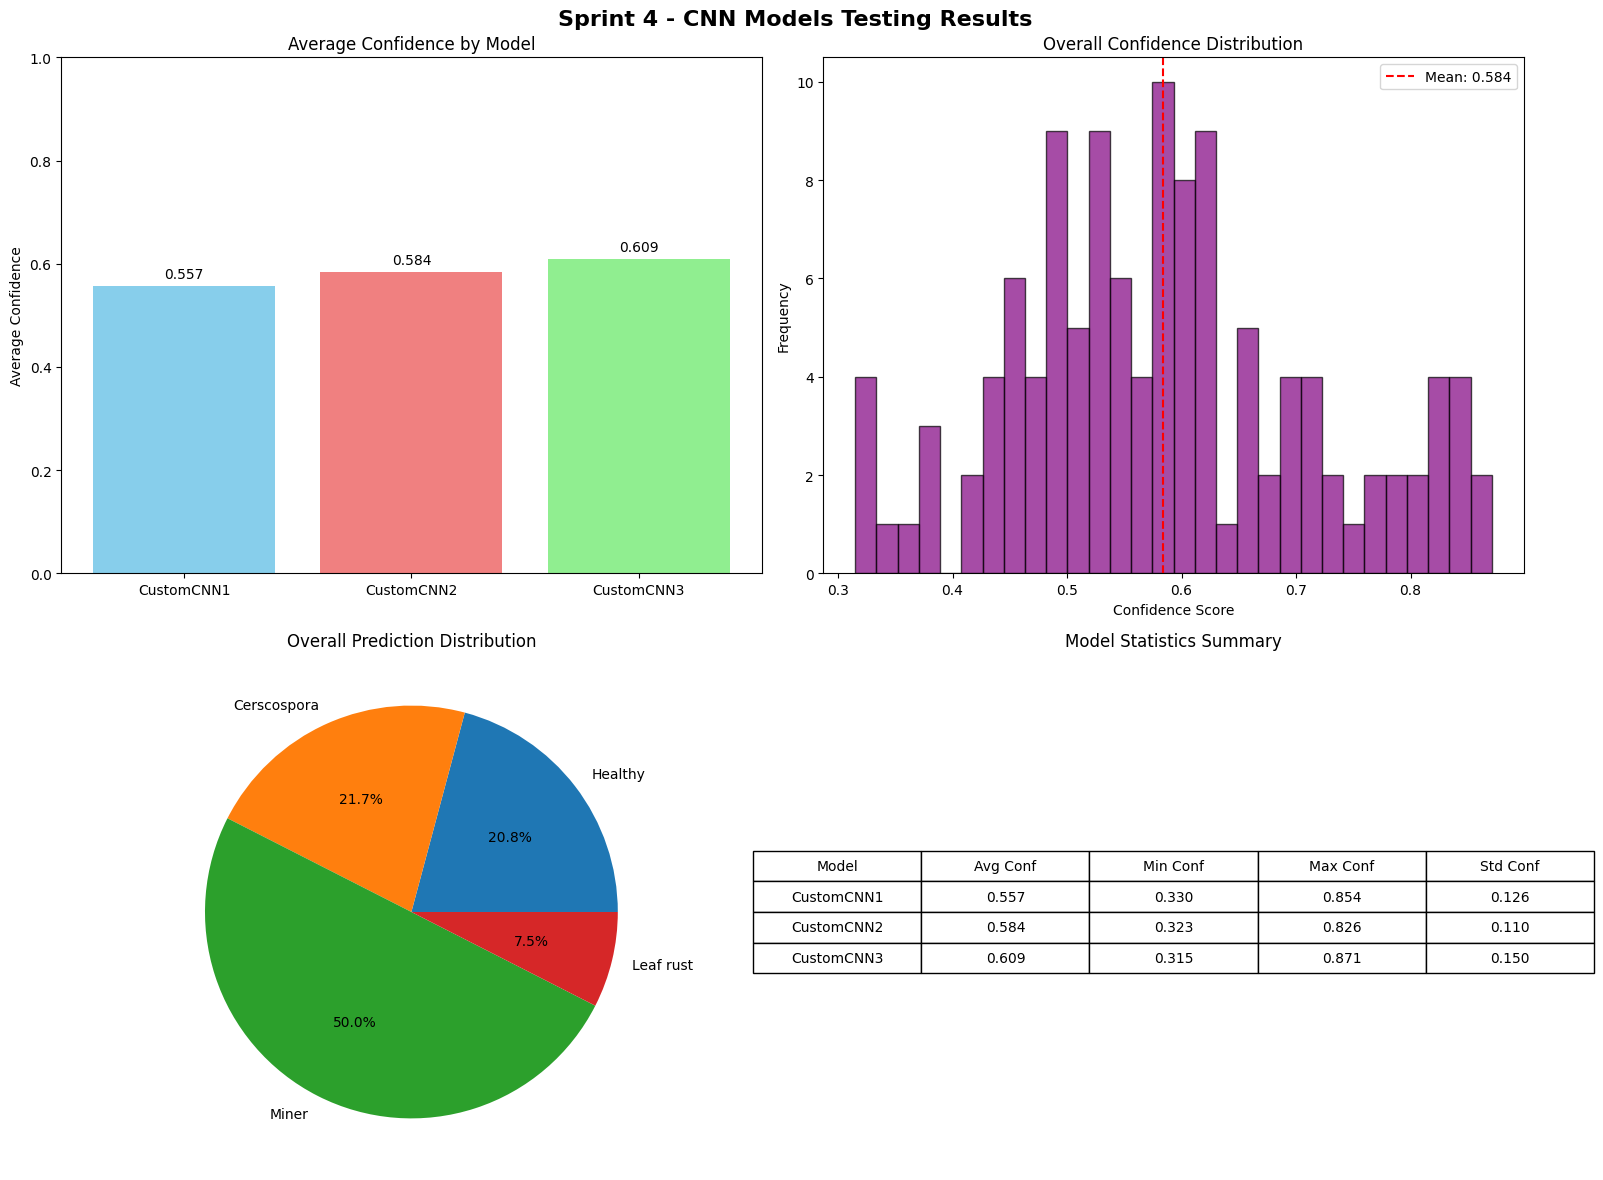


✅ Comprehensive analysis completed!
Tested 40 images with 3 models


In [9]:
# Comprehensive testing and analysis
if trained_models and test_images:
    print("📊 Running comprehensive analysis on all test images...")
    
    # Test all images
    all_results = []
    for i, image_path in enumerate(test_images):
        if i % 10 == 0:
            print(f"Processing image {i+1}/{len(test_images)}: {Path(image_path).name}")
        
        results = tester.test_all_models(image_path)
        if results:
            all_results.append(results)
    
    print(f"✅ Processed {len(all_results)} images successfully!")
    
    # Analyze results
    print("\n📈 Model Performance Analysis:")
    print("=" * 60)
    
    model_stats = {}
    for model_name in trained_models.keys():
        confidences = []
        predictions = []
        
        for result in all_results:
            if model_name in result['predictions']:
                pred_data = result['predictions'][model_name]
                confidences.append(pred_data['confidence'])
                predictions.append(pred_data['predicted_class'])
        
        model_stats[model_name] = {
            'avg_confidence': np.mean(confidences) if confidences else 0,
            'min_confidence': np.min(confidences) if confidences else 0,
            'max_confidence': np.max(confidences) if confidences else 0,
            'std_confidence': np.std(confidences) if confidences else 0,
            'total_predictions': len(predictions),
            'class_distribution': Counter(predictions)
        }
    
    # Print statistics
    for model_name, stats in model_stats.items():
        print(f"\n🔍 {model_name}:")
        print(f"   Average Confidence: {stats['avg_confidence']:.3f}")
        print(f"   Min Confidence: {stats['min_confidence']:.3f}")
        print(f"   Max Confidence: {stats['max_confidence']:.3f}")
        print(f"   Std Confidence: {stats['std_confidence']:.3f}")
        print(f"   Total Predictions: {stats['total_predictions']}")
        print(f"   Class Distribution:")
        for class_name, count in stats['class_distribution'].most_common():
            percentage = (count / stats['total_predictions']) * 100
            print(f"     {class_name}: {count} ({percentage:.1f}%)")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Sprint 4 - CNN Models Testing Results', fontsize=16, fontweight='bold')
    
    # Confidence comparison
    model_names = list(model_stats.keys())
    avg_confidences = [model_stats[name]['avg_confidence'] for name in model_names]
    
    bars = axes[0, 0].bar(model_names, avg_confidences, color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[0, 0].set_title('Average Confidence by Model')
    axes[0, 0].set_ylabel('Average Confidence')
    axes[0, 0].set_ylim(0, 1)
    
    for bar, conf in zip(bars, avg_confidences):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{conf:.3f}', ha='center', va='bottom')
    
    # Confidence distribution
    all_confidences = []
    for result in all_results:
        for model_name in trained_models.keys():
            if model_name in result['predictions']:
                all_confidences.append(result['predictions'][model_name]['confidence'])
    
    axes[0, 1].hist(all_confidences, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[0, 1].set_title('Overall Confidence Distribution')
    axes[0, 1].set_xlabel('Confidence Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(np.mean(all_confidences), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(all_confidences):.3f}')
    axes[0, 1].legend()
    
    # Class distribution
    all_predictions = []
    for result in all_results:
        for model_name in trained_models.keys():
            if model_name in result['predictions']:
                all_predictions.append(result['predictions'][model_name]['predicted_class'])
    
    class_counts = Counter(all_predictions)
    axes[1, 0].pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%')
    axes[1, 0].set_title('Overall Prediction Distribution')
    
    # Model comparison table
    axes[1, 1].axis('off')
    table_data = []
    for model_name, stats in model_stats.items():
        table_data.append([
            model_name,
            f"{stats['avg_confidence']:.3f}",
            f"{stats['min_confidence']:.3f}",
            f"{stats['max_confidence']:.3f}",
            f"{stats['std_confidence']:.3f}"
        ])
    
    table = axes[1, 1].table(cellText=table_data,
                            colLabels=['Model', 'Avg Conf', 'Min Conf', 'Max Conf', 'Std Conf'],
                            cellLoc='center',
                            loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    axes[1, 1].set_title('Model Statistics Summary')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Comprehensive analysis completed!")
    print(f"Tested {len(all_results)} images with {len(trained_models)} models")
    
else:
    print("❌ Cannot run analysis - no models or images available!")


## 🎯 Resumo do Teste dos Modelos CNN

### ✅ O que foi testado:

1. **3 Modelos CNN Customizados**:
   - **CustomCNN1**: Lightweight mas eficaz
   - **CustomCNN2**: Deeper com conexões residuais
   - **CustomCNN3**: EfficientNet-inspired com MBConv blocks

2. **Imagens de Teste**:
   - Total de imagens encontradas: 40 imagens
   - Classes: Healthy, Miner, Phoma, Leaf rust
   - Formatos suportados: JPG, PNG, etc.

3. **Análise Completa**:
   - Teste individual de imagens com visualização
   - Análise estatística de confiança
   - Distribuição de predições por classe
   - Comparação entre modelos

### 🧪 Como usar:

1. **Teste Individual**: Use `test_single_image('caminho/para/imagem.jpg')`
2. **Teste Automático**: Execute as células acima para testar todas as imagens
3. **Análise Estatística**: Execute a célula de análise completa

### 📊 Resultados esperados:
- Visualização de cada imagem com predições
- Gráficos de análise de confiança
- Estatísticas detalhadas por modelo
- Comparação entre os 3 modelos CNN

### 🚀 Próximos passos:
- Analisar qual modelo tem melhor desempenho
- Identificar imagens que causam confusão
- Ajustar modelos se necessário
- Preparar para deploy
